In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
from collections import Counter
import json
from sklearn.preprocessing import MinMaxScaler


# Step Counts

In [2]:
file_path = 'com.samsung.shealth.activity.day_summary.20240115183382.csv'

dates = []
step_counts = []

# read the file line by line, starting from the third
# line because first two lines have headings

with open(file_path, 'r') as file:
    file.readline() 
    header = file.readline() 
    
    for line in file:
        fields = line.strip().split(',')

        step_count = fields[4]  
        date_str = fields[10]   
        
        date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
        
        dates.append(date)
        step_counts.append(step_count)

df = pd.DataFrame({'date': dates, 'step_count': step_counts})

df['step_count'] = pd.to_numeric(df['step_count'], errors='coerce')

df['update_date'] = df['date'].dt.strftime('%Y-%m-%d')  


# new DataFrame with unique dates and the maximum step count (there were some records earlier in
# the same day so I get max of that day to get the step count of full day)

df_max_step = df.groupby('update_date')['step_count'].max().reset_index()

date_range = pd.date_range(start='2022-05-19', end='2024-01-15', freq='D')
df_all_dates = pd.DataFrame({'date': date_range})

df_max_step['update_date'] = pd.to_datetime(df_max_step['update_date'])

# merge the two DataFrames on date to fill missing dates
df_filled = pd.merge(df_all_dates, df_max_step, left_on='date', right_on='update_date', how='left')

# fill missing step counts with zero
df_filled['step_count'] = df_filled['step_count'].fillna(0)

print("\nFilled DataFrame:")
print(df_filled[['date', 'step_count']])



Filled DataFrame:
          date  step_count
0   2022-05-19         0.0
1   2022-05-20      8543.0
2   2022-05-21      5274.0
3   2022-05-22     10995.0
4   2022-05-23      5573.0
..         ...         ...
602 2024-01-11      5648.0
603 2024-01-12      5475.0
604 2024-01-13      9965.0
605 2024-01-14      9661.0
606 2024-01-15      4631.0

[607 rows x 2 columns]


# schedule

In [3]:
schedule_file_path = 'schedule.xlsx'  

df_schedule = pd.read_excel(schedule_file_path)

print(df_schedule)


          date  Lecture Hour
0   2022-08-15             0
1   2022-08-16             0
2   2022-08-17             0
3   2022-08-18             0
4   2022-08-19             0
..         ...           ...
518 2024-01-15             0
519 2024-01-16             0
520 2024-01-17             0
521 2024-01-18             0
522 2024-01-19             0

[523 rows x 2 columns]


# instagram likes


In [4]:
with open('liked_posts.json', 'r') as file:
    json_data = json.load(file)

dates = [datetime.utcfromtimestamp(entry['timestamp']).strftime('%Y-%m-%d') for like in json_data['likes_media_likes'] for entry in like['string_list_data']]

#there are dates of every like so I count the occurences of dates to see how many posts I liked in a date
date_occurrences = dict(Counter(dates))

df_likes = pd.DataFrame(list(date_occurrences.items()), columns=['date', 'likes'])

print(df_likes)


           date  likes
0    2024-01-15     13
1    2024-01-14     27
2    2024-01-13     45
3    2024-01-12      2
4    2024-01-11     12
..          ...    ...
879  2021-07-04     13
880  2021-07-03      6
881  2021-07-02     17
882  2021-07-01      2
883  2021-06-29      5

[884 rows x 2 columns]


### Merging the Data Frames and filtering the common dates

In [5]:

df_filled['date'] = pd.to_datetime(df_filled['date'])
df_likes['date'] = pd.to_datetime(df_likes['date'])
df_schedule['date'] = pd.to_datetime(df_schedule['date'])

df_merged_filled_likes = pd.merge(df_filled, df_likes, on='date', how='left')

df_merged_filled_likes_schedule = pd.merge(df_merged_filled_likes, df_schedule, on='date', how='outer')

df_merged_filled_likes_schedule = df_merged_filled_likes_schedule.drop(columns=['update_date'])

print(df_merged_filled_likes_schedule)

df_merged_filled_likes_schedule['date'] = pd.to_datetime(df_merged_filled_likes_schedule['date'])

# filter rows between '2022-08-15' and '2024-01-15' to avoid NaN values
date_range_condition = (df_merged_filled_likes_schedule['date'] >= '2022-08-15') & (df_merged_filled_likes_schedule['date'] <= '2024-01-15')
df_filtered = df_merged_filled_likes_schedule[date_range_condition]

# reset the index to start from 0
df_filtered = df_filtered.reset_index(drop=True)
print("The merged version of all available dates with information")

print(df_filtered)


          date  step_count  likes  Lecture Hour
0   2022-05-19         0.0   33.0           NaN
1   2022-05-20      8543.0   34.0           NaN
2   2022-05-21      5274.0   16.0           NaN
3   2022-05-22     10995.0    7.0           NaN
4   2022-05-23      5573.0   20.0           NaN
..         ...         ...    ...           ...
606 2024-01-15      4631.0   13.0           0.0
607 2024-01-16         NaN    NaN           0.0
608 2024-01-17         NaN    NaN           0.0
609 2024-01-18         NaN    NaN           0.0
610 2024-01-19         NaN    NaN           0.0

[611 rows x 4 columns]
The merged version of all available dates with information
          date  step_count  likes  Lecture Hour
0   2022-08-15      9180.0    7.0           0.0
1   2022-08-16       102.0   17.0           0.0
2   2022-08-17       727.0   49.0           0.0
3   2022-08-18       168.0   54.0           0.0
4   2022-08-19      2000.0   21.0           0.0
..         ...         ...    ...           ...
514 2

# visualization


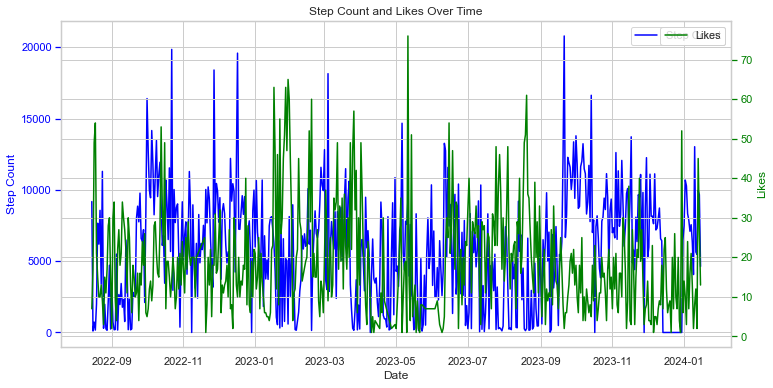

In [6]:
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(x='date', y='step_count', data=df_filtered, ax=ax1, label='Step Count', color='blue')
ax1.set_ylabel('Step Count', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
sns.lineplot(x='date', y='likes', data=df_filtered, ax=ax2, label='Likes', color='green')
ax2.set_ylabel('Likes', color='green')
ax2.tick_params('y', colors='green')

ax1.set_xlabel('Date')

plt.title('Step Count and Likes Over Time')

plt.show()

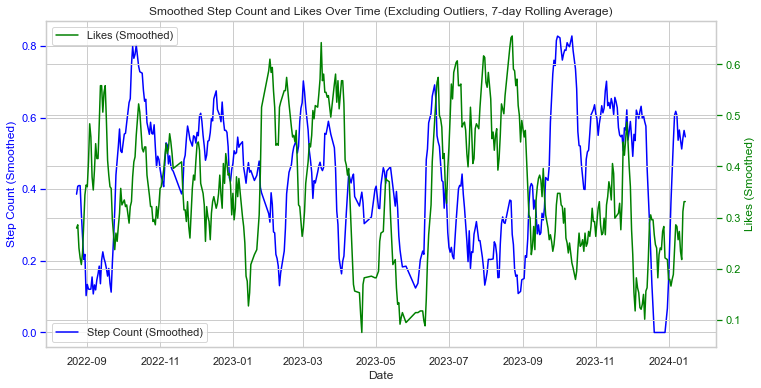

In [7]:

df_normalized = df_filtered.copy()

std_dev_threshold = 2  


mean_step_count = df_normalized['step_count'].mean()
std_step_count = df_normalized['step_count'].std()
df_normalized = df_normalized[(df_normalized['step_count'] >= mean_step_count - std_dev_threshold * std_step_count) &
                              (df_normalized['step_count'] <= mean_step_count + std_dev_threshold * std_step_count)]


mean_likes = df_normalized['likes'].mean()
std_likes = df_normalized['likes'].std()
df_normalized = df_normalized[(df_normalized['likes'] >= mean_likes - std_dev_threshold * std_likes) &
                              (df_normalized['likes'] <= mean_likes + std_dev_threshold * std_likes)]


scaler = MinMaxScaler()

df_normalized[['step_count', 'likes']] = scaler.fit_transform(df_normalized[['step_count', 'likes']])

window_size = 7  
df_normalized[['step_count', 'likes']] = df_normalized[['step_count', 'likes']].rolling(window=window_size).mean()

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(x='date', y='step_count', data=df_normalized, ax=ax1, label='Step Count (Smoothed)', color='blue')
ax1.set_ylabel('Step Count (Smoothed)', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
sns.lineplot(x='date', y='likes', data=df_normalized, ax=ax2, label='Likes (Smoothed)', color='green')
ax2.set_ylabel('Likes (Smoothed)', color='green')
ax2.tick_params('y', colors='green')

ax1.set_xlabel('Date')


plt.title(f'Smoothed Step Count and Likes Over Time (Excluding Outliers, {window_size}-day Rolling Average)')
plt.legend(loc='upper left')
plt.show()


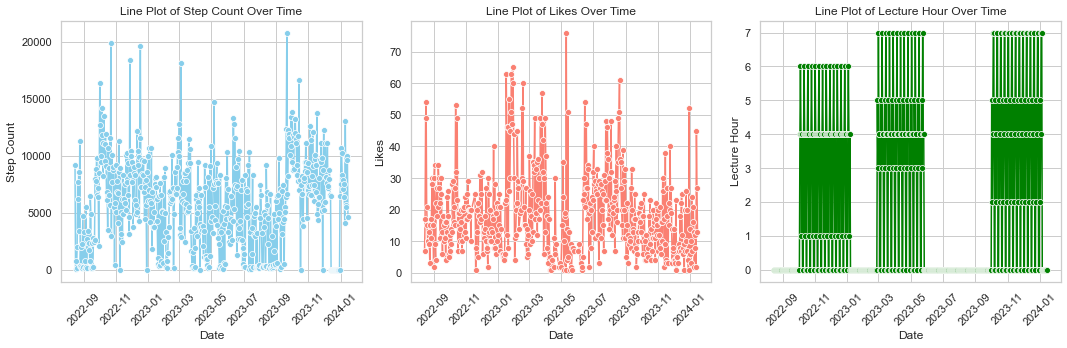

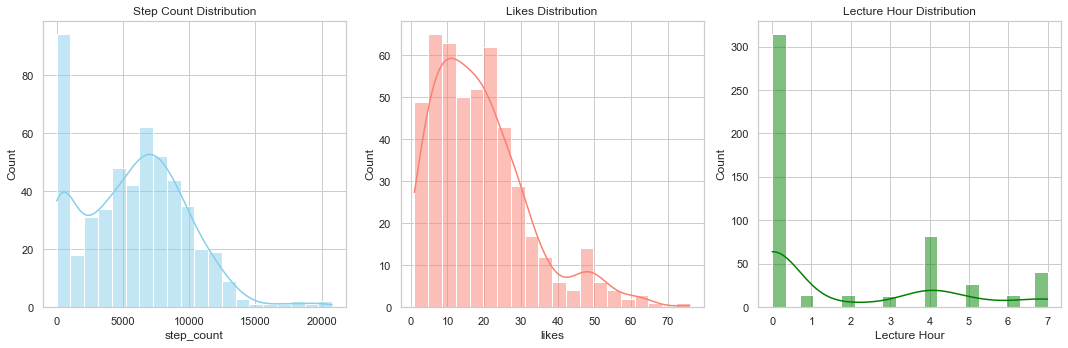

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.lineplot(x='date', y='step_count', data=df_filtered, marker='o', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.title('Line Plot of Step Count Over Time')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.lineplot(x='date', y='likes', data=df_filtered, marker='o', color='salmon')
plt.xlabel('Date')
plt.ylabel('Likes')
plt.title('Line Plot of Likes Over Time')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.lineplot(x='date', y='Lecture Hour', data=df_filtered, marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('Lecture Hour')
plt.title('Line Plot of Lecture Hour Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_filtered['step_count'], bins=20, kde=True, color='skyblue')
plt.title('Step Count Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df_filtered['likes'], bins=20, kde=True, color='salmon')
plt.title('Likes Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df_filtered['Lecture Hour'], bins=20, kde=True, color='green')
plt.title('Lecture Hour Distribution')

plt.tight_layout()
plt.show()


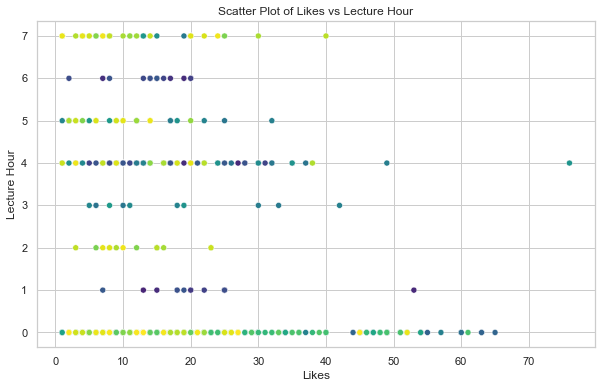

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='likes', y='Lecture Hour', data=df_filtered, hue='date', palette='viridis',legend=False)
plt.xlabel('Likes')
plt.ylabel('Lecture Hour')
plt.title('Scatter Plot of Likes vs Lecture Hour')
plt.show()


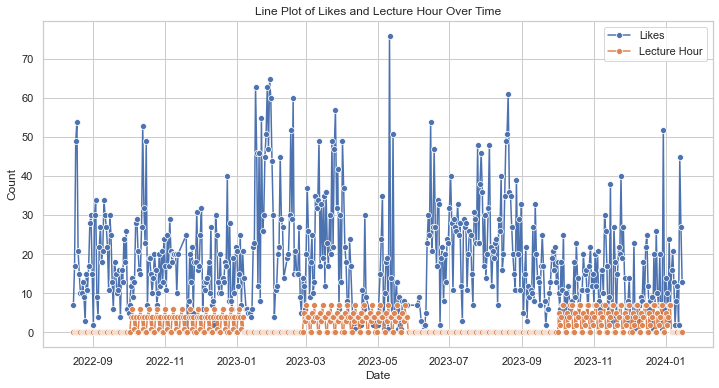

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='likes', data=df_filtered, label='Likes', marker='o')
sns.lineplot(x='date', y='Lecture Hour', data=df_filtered, label='Lecture Hour', marker='o')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Line Plot of Likes and Lecture Hour Over Time')
plt.legend()
plt.show()


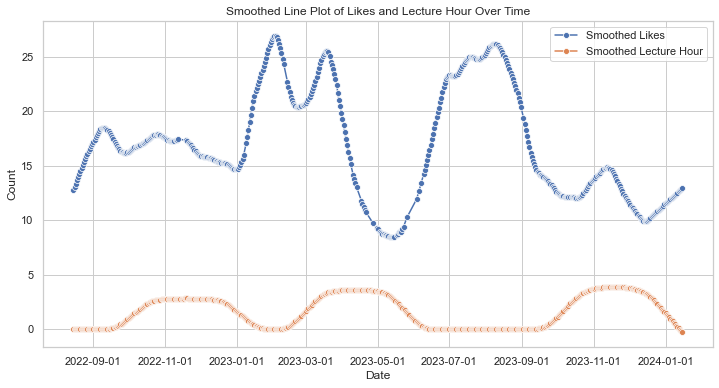

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates

sns.set(style="whitegrid")

lowess_likes = sm.nonparametric.lowess(df_filtered['likes'], df_filtered['date'], frac=0.1)
lowess_lecture_hour = sm.nonparametric.lowess(df_filtered['Lecture Hour'], df_filtered['date'], frac=0.1)

df_smoothed_likes = pd.DataFrame(lowess_likes, columns=['date', 'smoothed_likes'])
df_smoothed_lecture_hour = pd.DataFrame(lowess_lecture_hour, columns=['date', 'smoothed_lecture_hour'])

df_smoothed_likes['date'] = pd.to_datetime(df_smoothed_likes['date'])
df_smoothed_lecture_hour['date'] = pd.to_datetime(df_smoothed_lecture_hour['date'])

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='smoothed_likes', data=df_smoothed_likes, label='Smoothed Likes', marker='o')
sns.lineplot(x='date', y='smoothed_lecture_hour', data=df_smoothed_lecture_hour, label='Smoothed Lecture Hour', marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Smoothed Line Plot of Likes and Lecture Hour Over Time')
plt.legend()
plt.show()


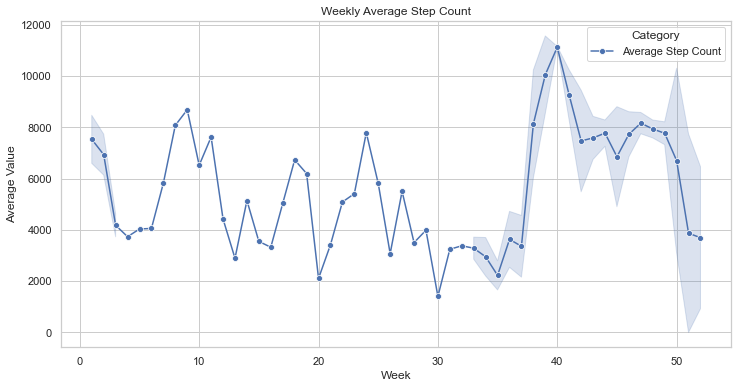

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'step_count': 'mean',
    'likes': 'mean'
}).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='step_count', data=df_weekly_avg, label='Average Step Count', marker='o')
plt.xlabel('Week')
plt.ylabel('Average Value')
plt.title('Weekly Average Step Count')
plt.legend(title='Category')
plt.show()


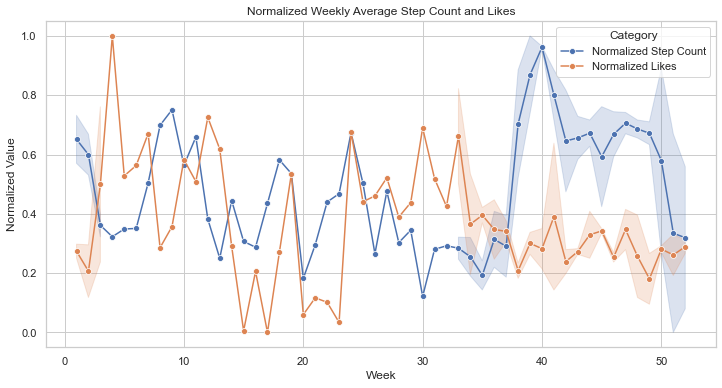

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'step_count': 'mean',
    'likes': 'mean'
}).reset_index()

df_weekly_avg['step_count_normalized'] = (df_weekly_avg['step_count'] - df_weekly_avg['step_count'].min()) / (
        df_weekly_avg['step_count'].max() - df_weekly_avg['step_count'].min())

df_weekly_avg['likes_normalized'] = (df_weekly_avg['likes'] - df_weekly_avg['likes'].min()) / (
        df_weekly_avg['likes'].max() - df_weekly_avg['likes'].min())

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='step_count_normalized', data=df_weekly_avg, label='Normalized Step Count', marker='o')
sns.lineplot(x='week', y='likes_normalized', data=df_weekly_avg, label='Normalized Likes', marker='o')
plt.xlabel('Week')
plt.ylabel('Normalized Value')
plt.title('Normalized Weekly Average Step Count and Likes')
plt.legend(title='Category')
plt.show()


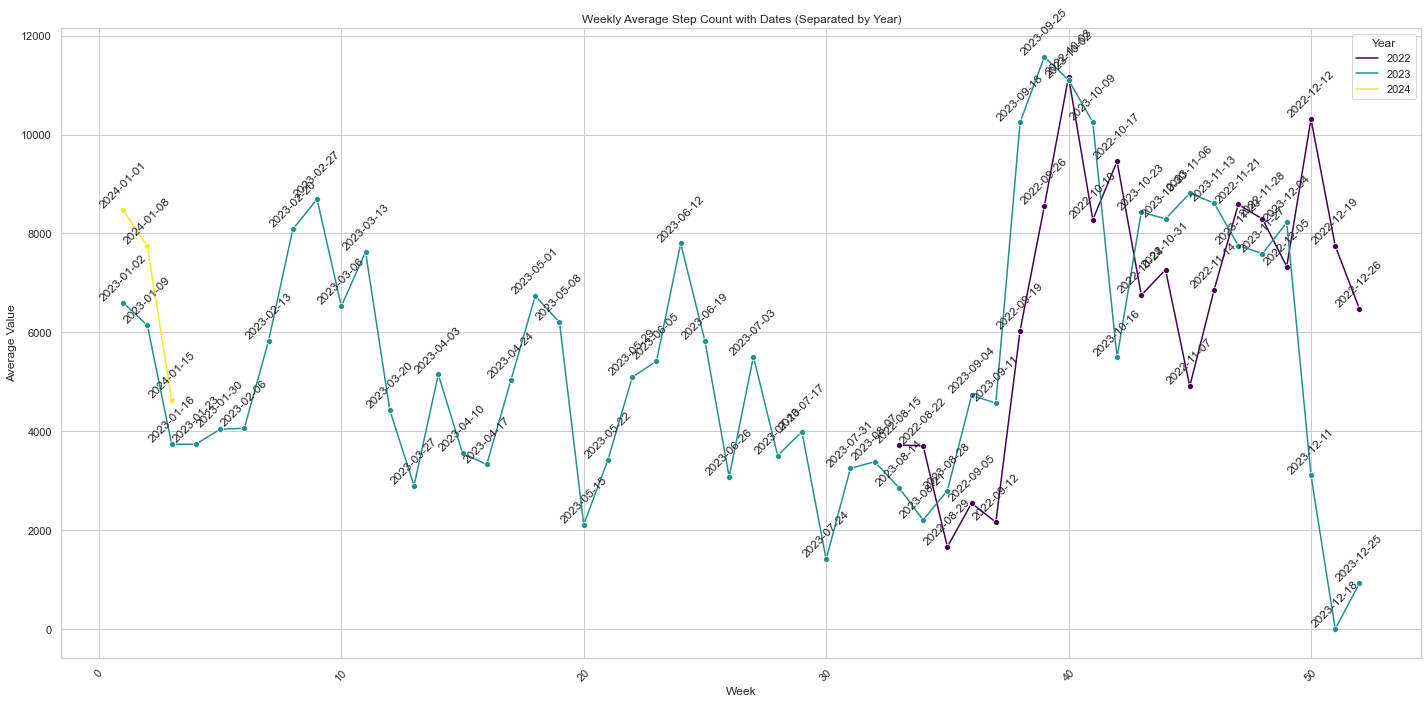

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'step_count': 'mean',
    'likes': 'mean',
    'date': 'first' 
}).reset_index()


sns.set(style="whitegrid")

plt.figure(figsize=(20, 10))
sns.lineplot(x='week', y='step_count', data=df_weekly_avg, hue='year', palette='viridis', marker='o')


for i, row in df_weekly_avg.iterrows():
    plt.text(row['week'], row['step_count'], f"{row['date'].strftime('%Y-%m-%d')}", ha='center', va='bottom', rotation=45)

plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Average Value')
plt.title('Weekly Average Step Count with Dates (Separated by Year)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()


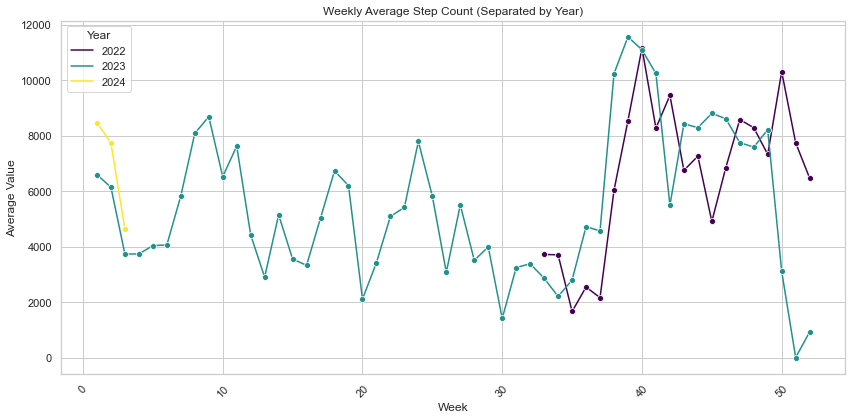

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'step_count': 'mean',
    'likes': 'mean',
    'date': 'first' 
}).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='step_count', data=df_weekly_avg, hue='year', palette='viridis', marker='o')

plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Average Value')
plt.title('Weekly Average Step Count (Separated by Year)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()


              step_count     likes  Lecture Hour
step_count      1.000000 -0.238293      0.168240
likes          -0.238293  1.000000     -0.249649
Lecture Hour    0.168240 -0.249649      1.000000


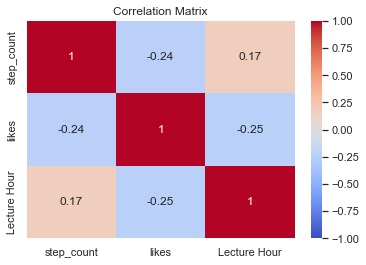

In [16]:
correlation_matrix = df_filtered[['step_count', 'likes', 'Lecture Hour']].corr()

print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [17]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          519 non-null    datetime64[ns]
 1   step_count    519 non-null    float64       
 2   likes         483 non-null    float64       
 3   Lecture Hour  519 non-null    float64       
 4   week          519 non-null    UInt32        
 5   year          519 non-null    UInt32        
dtypes: UInt32(2), datetime64[ns](1), float64(3)
memory usage: 21.4 KB


# Time Series Analysis

### step count

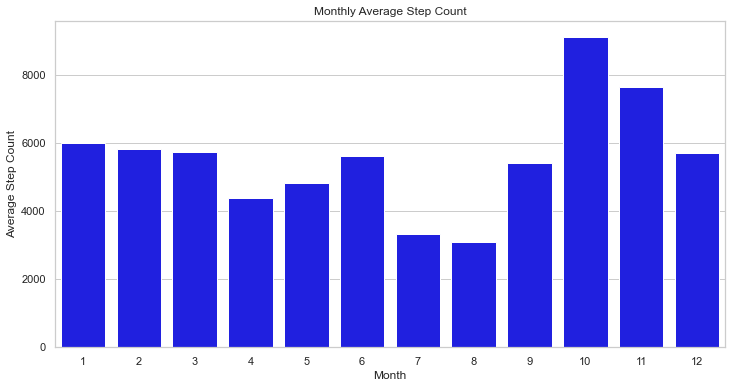

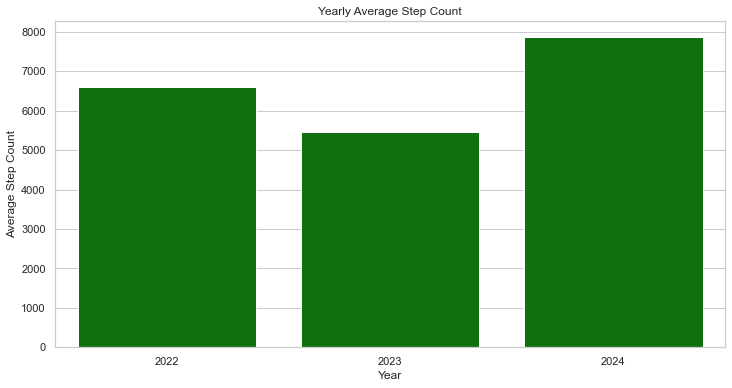

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['year'] = df_filtered['date'].dt.year

monthly_avg = df_filtered.groupby('month')['step_count'].mean()
yearly_avg = df_filtered.groupby('year')['step_count'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, color='blue')
plt.xlabel('Month')
plt.ylabel('Average Step Count')
plt.title('Monthly Average Step Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_avg.index, y=yearly_avg.values, color='green')
plt.xlabel('Year')
plt.ylabel('Average Step Count')
plt.title('Yearly Average Step Count')
plt.show()


[<class 'float'>]
        date  step_count  likes  Lecture Hour  week  year  month
0 2022-08-15      9180.0    7.0           0.0    33  2022      8
1 2022-08-16       102.0   17.0           0.0    33  2022      8
2 2022-08-17       727.0   49.0           0.0    33  2022      8
3 2022-08-18       168.0   54.0           0.0    33  2022      8
4 2022-08-19      2000.0   21.0           0.0    33  2022      8


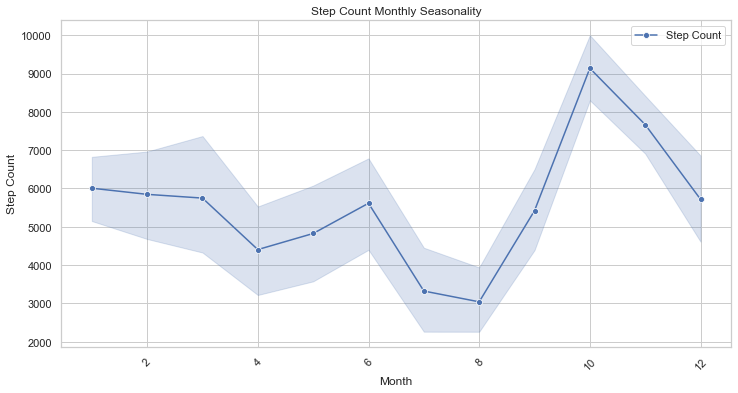

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print(df_filtered['step_count'].apply(type).unique())
print(df_filtered.head())

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='step_count', data=df_filtered[2:], label='Step Count', marker='o')
plt.xlabel('Month')
plt.ylabel('Step Count')
plt.title('Step Count Monthly Seasonality')
plt.xticks(rotation=45)
plt.legend()
plt.show()


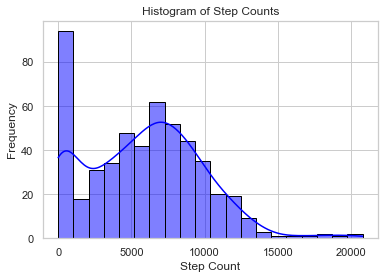

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

step_count_values = df_filtered['step_count']

sns.histplot(step_count_values, bins=20, kde=True, color='blue', edgecolor='black')

plt.xlabel('Step Count')
plt.ylabel('Frequency')
plt.title('Histogram of Step Counts')
plt.show()

### instagram likes

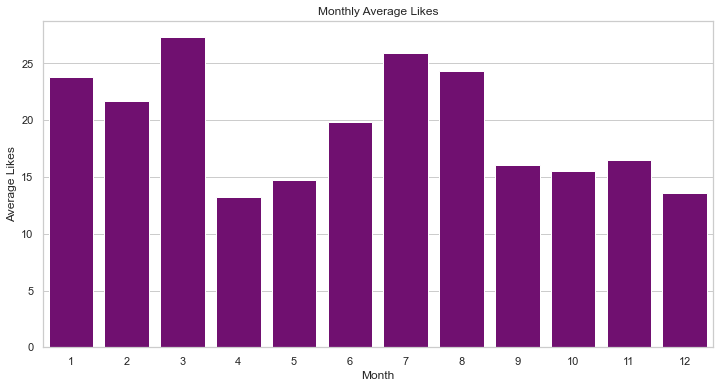

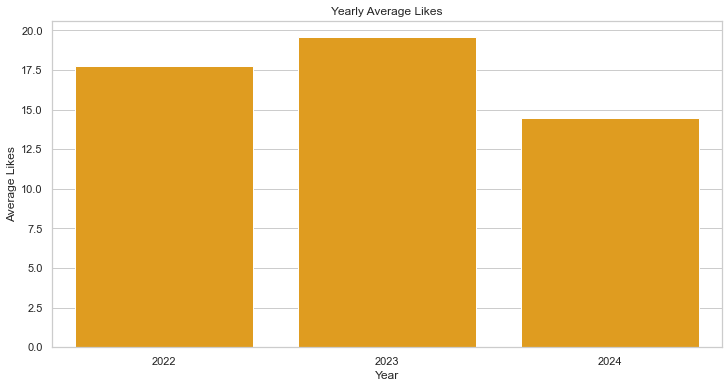

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['year'] = df_filtered['date'].dt.year

monthly_avg_likes = df_filtered.groupby('month')['likes'].mean()
yearly_avg_likes = df_filtered.groupby('year')['likes'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg_likes.index, y=monthly_avg_likes.values, color='purple')
plt.xlabel('Month')
plt.ylabel('Average Likes')
plt.title('Monthly Average Likes')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_avg_likes.index, y=yearly_avg_likes.values, color='orange')
plt.xlabel('Year')
plt.ylabel('Average Likes')
plt.title('Yearly Average Likes')
plt.show()


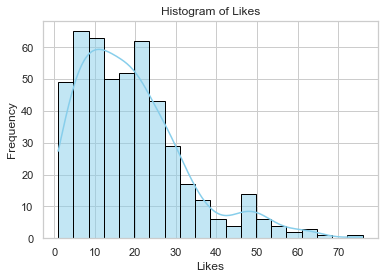

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

likes_values = df_filtered['likes']

sns.histplot(likes_values, bins=20, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.title('Histogram of Likes')
plt.show()

### lecture hours 

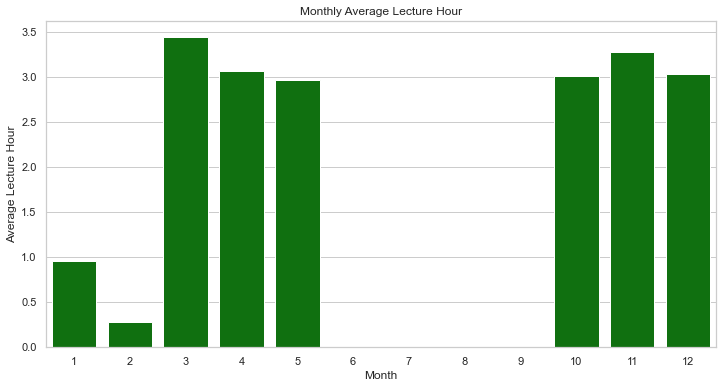

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['month'] = df_filtered['date'].dt.month

monthly_avg_lecture_hour = df_filtered.groupby('month')['Lecture Hour'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg_lecture_hour.index, y=monthly_avg_lecture_hour.values, color='green')
plt.xlabel('Month')
plt.ylabel('Average Lecture Hour')
plt.title('Monthly Average Lecture Hour')
plt.show()


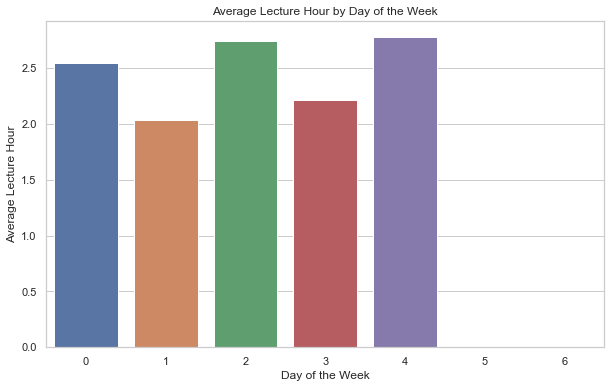

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['day_of_week'] = df_filtered['date'].dt.day_of_week

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day_of_week_avg = df_filtered.groupby('day_of_week')['Lecture Hour'].mean().reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='Lecture Hour', data=df_day_of_week_avg)
plt.xlabel('Day of the Week')
plt.ylabel('Average Lecture Hour')
plt.title('Average Lecture Hour by Day of the Week')
plt.show()


## compare monthly 

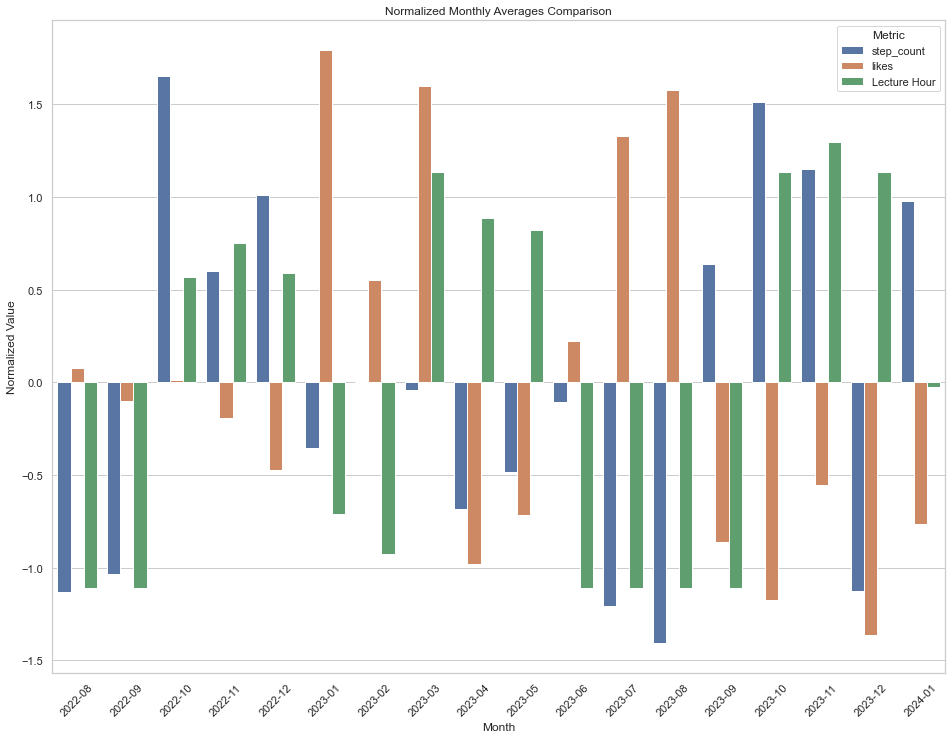

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['month'] = df_filtered['date'].dt.to_period('M')
df_monthly_avg = df_filtered.groupby('month').agg({
    'step_count': 'mean',
    'likes': 'mean',
    'Lecture Hour': 'mean'
}).reset_index()

def zscore_normalize(series):
    return (series - series.mean()) / series.std()

df_monthly_avg_normalized = df_monthly_avg.copy()
df_monthly_avg_normalized[['step_count', 'likes', 'Lecture Hour']] = df_monthly_avg_normalized[['step_count', 'likes', 'Lecture Hour']].apply(zscore_normalize)

df_monthly_avg_normalized_melted = pd.melt(df_monthly_avg_normalized, id_vars='month', var_name='Metric', value_name='Normalized Value')

sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
sns.barplot(x='month', y='Normalized Value', hue='Metric', data=df_monthly_avg_normalized_melted)
plt.xlabel('Month')
plt.ylabel('Normalized Value')
plt.title('Normalized Monthly Averages Comparison')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()


In [26]:
df_monthly_avg

month   step_count      likes  Lecture Hour
0   2022-08  3480.411765  19.058824      0.000000
1   2022-09  3677.500000  18.066667      0.000000
2   2022-10  9285.516129  18.709677      2.580645
3   2022-11  7092.700000  17.583333      2.866667
4   2022-12  7948.419355  16.032258      2.612903
5   2023-01  5102.290323  28.433333      0.612903
6   2023-02  5846.678571  21.653846      0.285714
7   2023-03  5749.064516  27.354839      3.451613
8   2023-04  4405.033333  13.263158      3.066667
9   2023-05  4825.290323  14.727273      2.967742
10  2023-06  5614.333333  19.840000      0.000000
11  2023-07  3323.129032  25.903226      0.000000
12  2023-08  2903.903226  27.258065      0.000000
13  2023-09  7164.666667  13.931034      0.000000
14  2023-10  8988.838710  12.200000      3.451613
15  2023-11  8240.733333  15.600000      3.700000
16  2023-12  3486.225806  11.193548      3.451613
17  2024-01  7875.933333  14.466667      1.666667

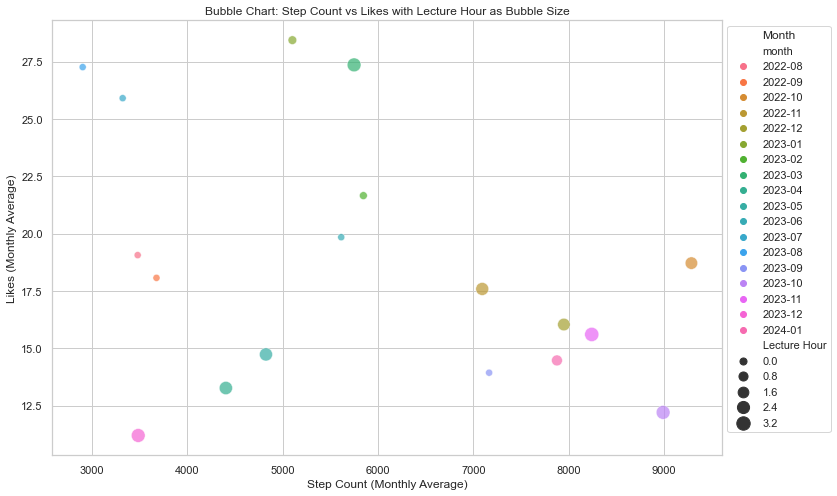

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['month'] = df_filtered['date'].dt.to_period('M')

df_monthly_avg = df_filtered.groupby('month').agg({
    'step_count': 'mean',
    'likes': 'mean',
    'Lecture Hour': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='step_count', y='likes', size='Lecture Hour', hue='month', data=df_monthly_avg, sizes=(50, 200), alpha=0.7)
plt.xlabel('Step Count (Monthly Average)')
plt.ylabel('Likes (Monthly Average)')
plt.title('Bubble Chart: Step Count vs Likes with Lecture Hour as Bubble Size')
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.show()


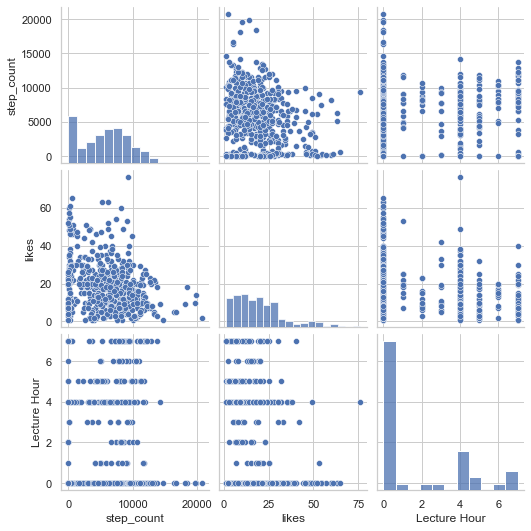

In [28]:
import seaborn as sns

selected_columns = ['step_count', 'likes', 'Lecture Hour']

sns.pairplot(df_filtered[selected_columns])
plt.show()


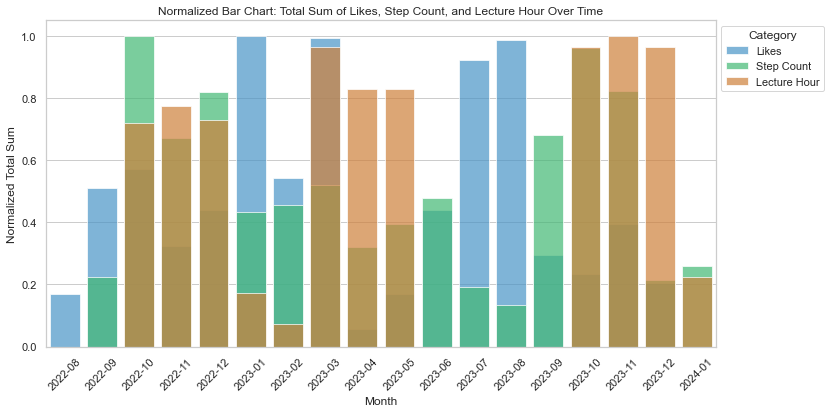

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


df_filtered['month'] = df_filtered['date'].dt.to_period('M')

df_grouped = df_filtered.groupby('month')[['likes', 'step_count', 'Lecture Hour']].sum().reset_index()

scaler = MinMaxScaler()
df_grouped_normalized = df_grouped.copy()
df_grouped_normalized[['likes', 'step_count', 'Lecture Hour']] = scaler.fit_transform(df_grouped[['likes', 'step_count', 'Lecture Hour']])

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='likes', data=df_grouped_normalized, color='#3498db', label='Likes', alpha=0.7)
sns.barplot(x='month', y='step_count', data=df_grouped_normalized, color='#2ecc71', label='Step Count', alpha=0.7)
sns.barplot(x='month', y='Lecture Hour', data=df_grouped_normalized, color='#e67e22', label='Lecture Hour', alpha=0.7)

plt.xlabel('Month')
plt.ylabel('Normalized Total Sum')
plt.title('Normalized Bar Chart: Total Sum of Likes, Step Count, and Lecture Hour Over Time')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()


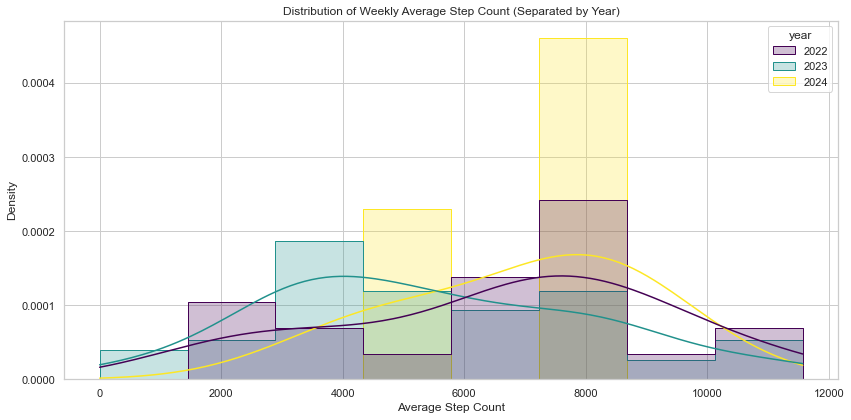

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'step_count': 'mean'
}).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(data=df_weekly_avg, x='step_count', hue='year', element='step', stat='density', common_norm=False, kde=True, palette='viridis')

plt.xlabel('Average Step Count')
plt.ylabel('Density')
plt.title('Distribution of Weekly Average Step Count (Separated by Year)')
plt.tight_layout()
plt.show()


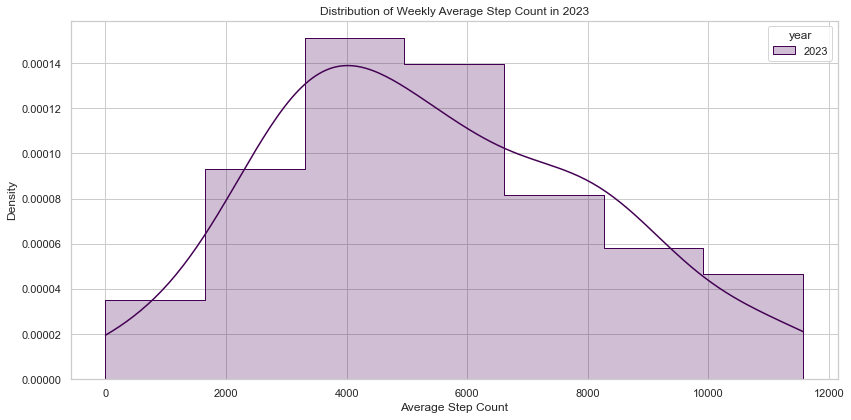

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_filtered_2023 = df_filtered[df_filtered['year'] == 2023]

df_weekly_avg_2023 = df_filtered_2023.groupby(['year', 'week']).agg({
    'step_count': 'mean'
}).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(data=df_weekly_avg_2023, x='step_count', hue='year', element='step', stat='density', common_norm=False, kde=True, palette='viridis')

plt.xlabel('Average Step Count')
plt.ylabel('Density')
plt.title('Distribution of Weekly Average Step Count in 2023')
plt.tight_layout()
plt.show()


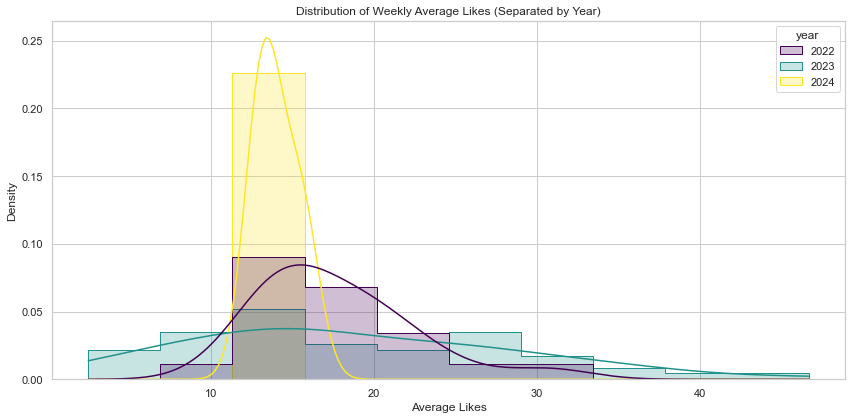

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg_likes = df_filtered.groupby(['year', 'week']).agg({
    'likes': 'mean'
}).reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(data=df_weekly_avg_likes, x='likes', hue='year', element='step', stat='density', common_norm=False, kde=True, palette='viridis')

plt.xlabel('Average Likes')
plt.ylabel('Density')
plt.title('Distribution of Weekly Average Likes (Separated by Year)')
plt.tight_layout()
plt.show()


# EDA Multivariate

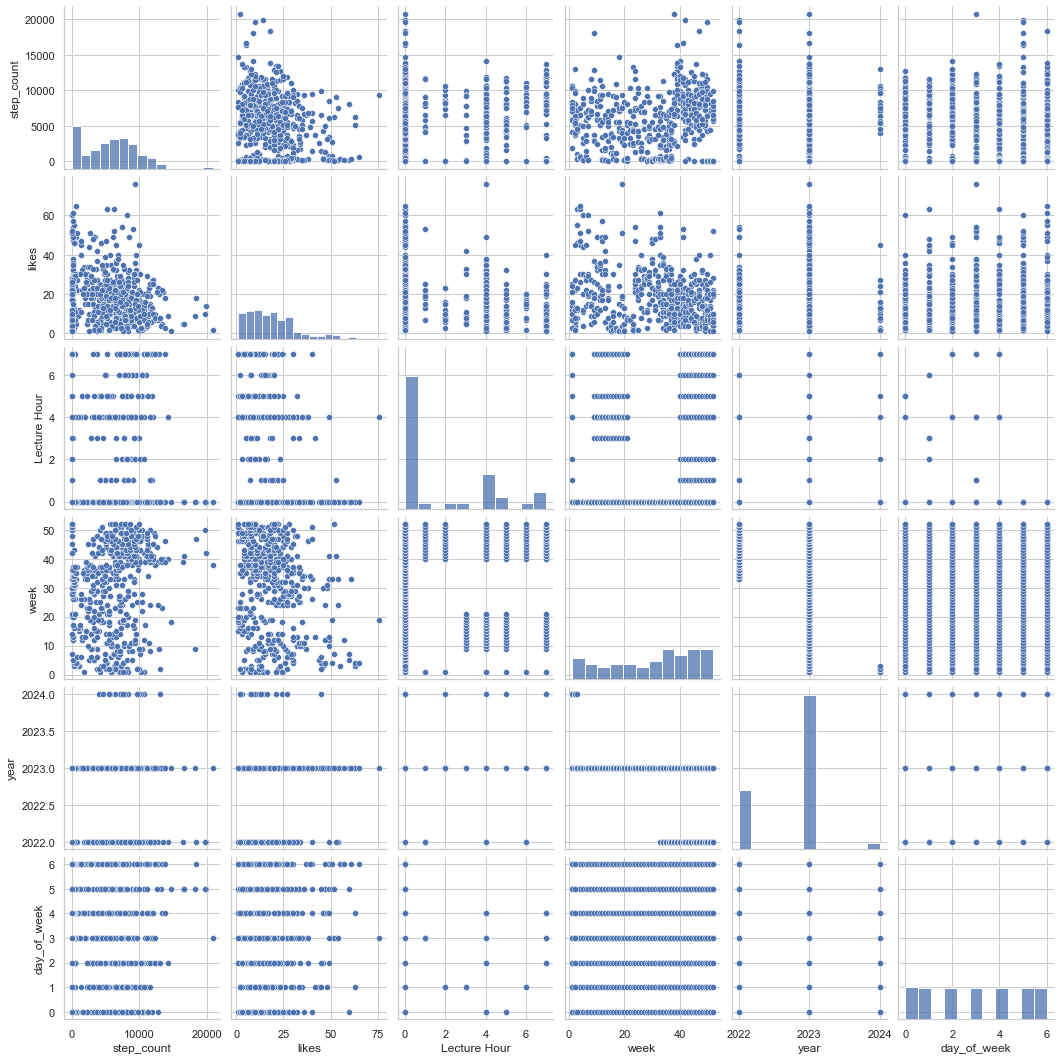

In [33]:
import seaborn as sns
sns.pairplot(df_filtered)
plt.show()


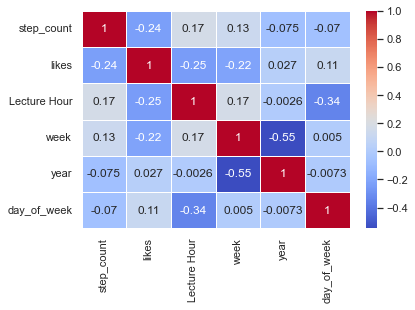

In [34]:
corr_matrix = df_filtered.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


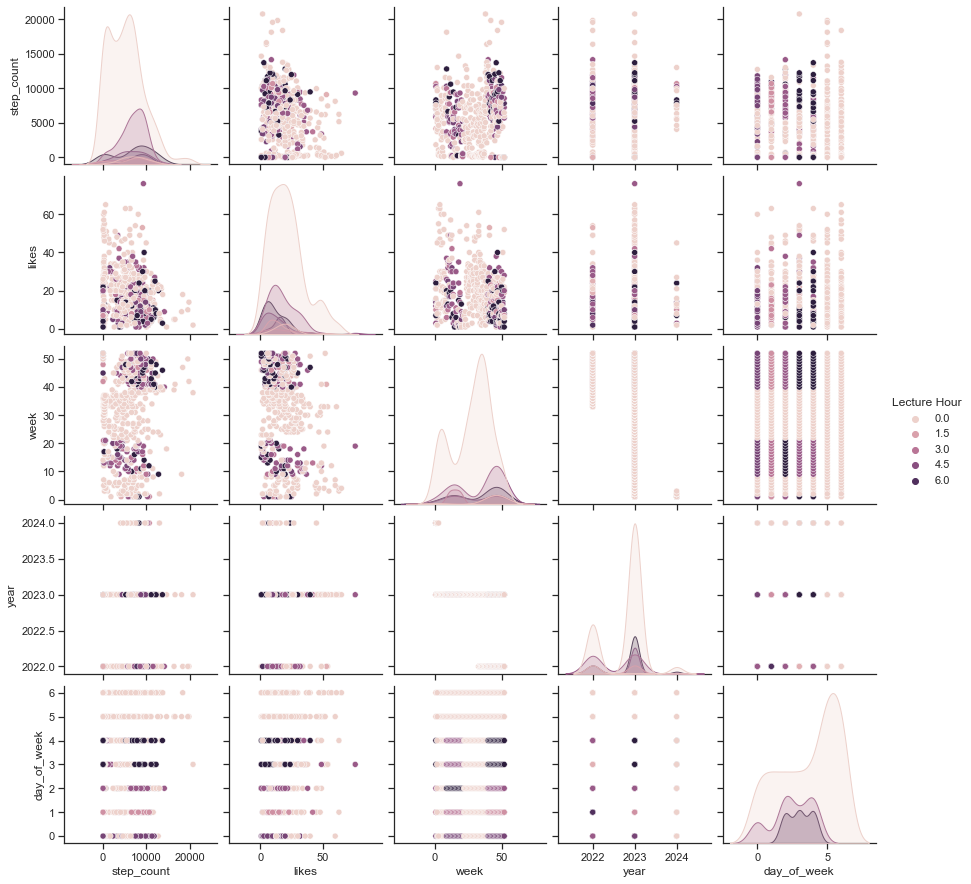

In [35]:
sns.set(style="ticks")
sns.pairplot(df_filtered, hue="Lecture Hour")
plt.show()


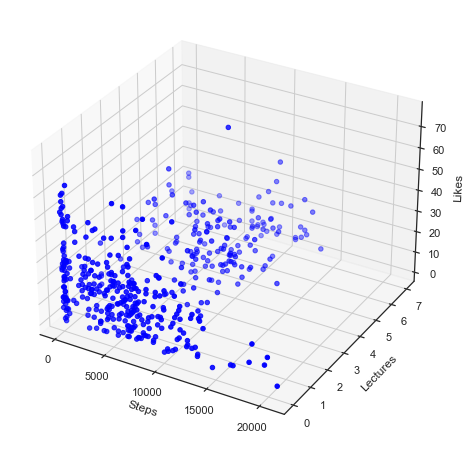

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_filtered['step_count'], df_filtered['Lecture Hour'], df_filtered['likes'], c='blue', marker='o')
ax.set_xlabel('Steps')
ax.set_ylabel('Lectures')
ax.set_zlabel('Likes')
plt.show()


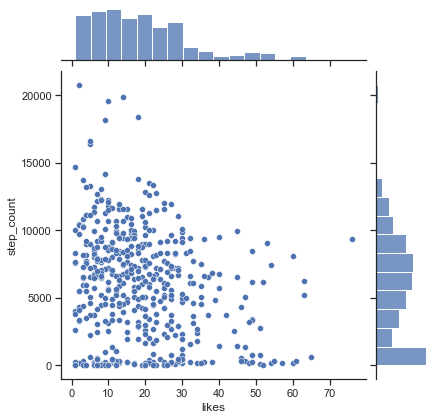

In [37]:
sns.jointplot(x='likes', y='step_count', data=df_filtered, kind='scatter')
plt.show()


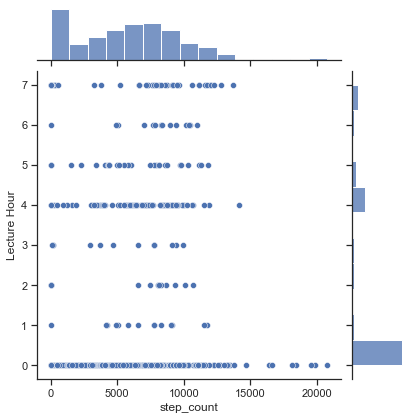

In [38]:
sns.jointplot(x='step_count', y='Lecture Hour', data=df_filtered, kind='scatter')
plt.show()


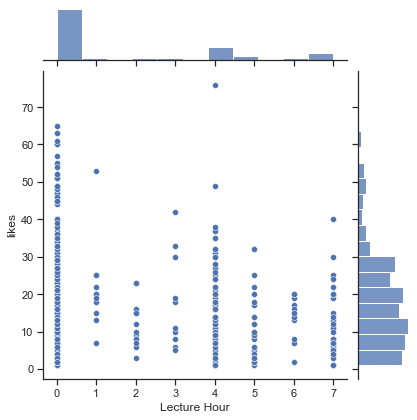

In [39]:
sns.jointplot(x='Lecture Hour', y='likes', data=df_filtered, kind='scatter')
plt.show()


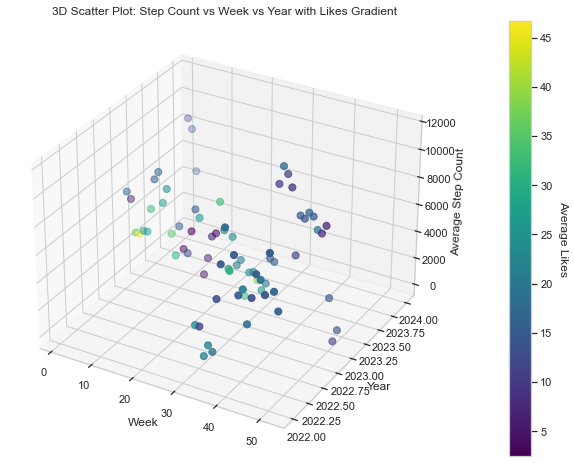

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'likes': 'mean',
    'step_count': 'mean'
}).reset_index()

sns.set(style="whitegrid")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_weekly_avg['week'], df_weekly_avg['year'], df_weekly_avg['step_count'],
                c=df_weekly_avg['likes'], cmap='viridis', s=50, depthshade=True)

cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Average Likes', rotation=270, labelpad=15)

ax.set_xlabel('Week')
ax.set_ylabel('Year')
ax.set_zlabel('Average Step Count')
ax.set_title('3D Scatter Plot: Step Count vs Week vs Year with Likes Gradient')

plt.show()


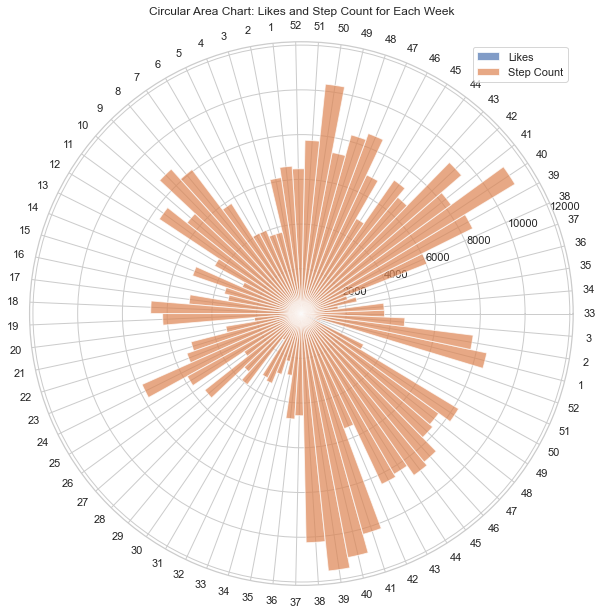

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'likes': 'mean',
    'step_count': 'mean'
}).reset_index()

plt.figure(figsize=(10, 10))

theta = np.linspace(0, 2*np.pi, len(df_weekly_avg['week']), endpoint=False)
width = 2*np.pi / len(df_weekly_avg['week'])

ax = plt.subplot(111, projection='polar')
ax.bar(theta, df_weekly_avg['likes'], width=width, alpha=0.7, label='Likes')

ax.bar(theta, df_weekly_avg['step_count'], width=width, alpha=0.7, label='Step Count')

ax.set_xticks(theta)
ax.set_xticklabels(df_weekly_avg['week'])
ax.set_title('Circular Area Chart: Likes and Step Count for Each Week')
ax.legend(loc='upper right')

plt.show()


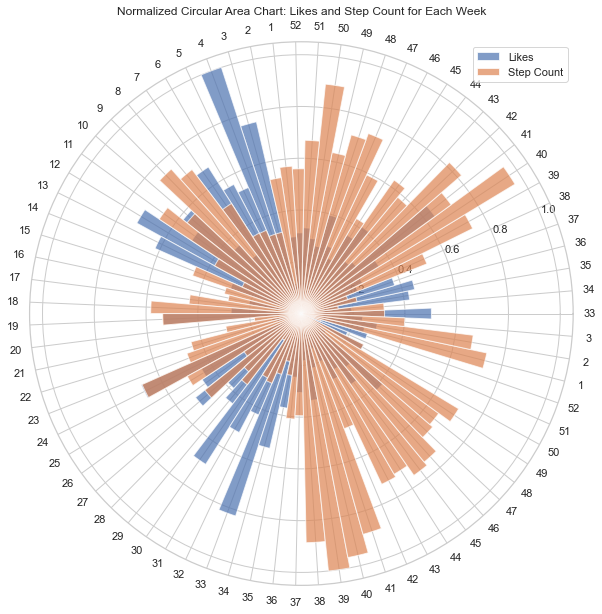

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'likes': 'mean',
    'step_count': 'mean'
}).reset_index()

scaler = MinMaxScaler()
df_weekly_avg[['likes', 'step_count']] = scaler.fit_transform(df_weekly_avg[['likes', 'step_count']])

plt.figure(figsize=(10, 10))

theta = np.linspace(0, 2*np.pi, len(df_weekly_avg['week']), endpoint=False)
width = 2*np.pi / len(df_weekly_avg['week'])

ax = plt.subplot(111, projection='polar')
ax.bar(theta, df_weekly_avg['likes'], width=width, alpha=0.7, label='Likes')

ax.bar(theta, df_weekly_avg['step_count'], width=width, alpha=0.7, label='Step Count')

ax.set_xticks(theta)
ax.set_xticklabels(df_weekly_avg['week'])
ax.set_title('Normalized Circular Area Chart: Likes and Step Count for Each Week')
ax.legend(loc='upper right')

plt.show()


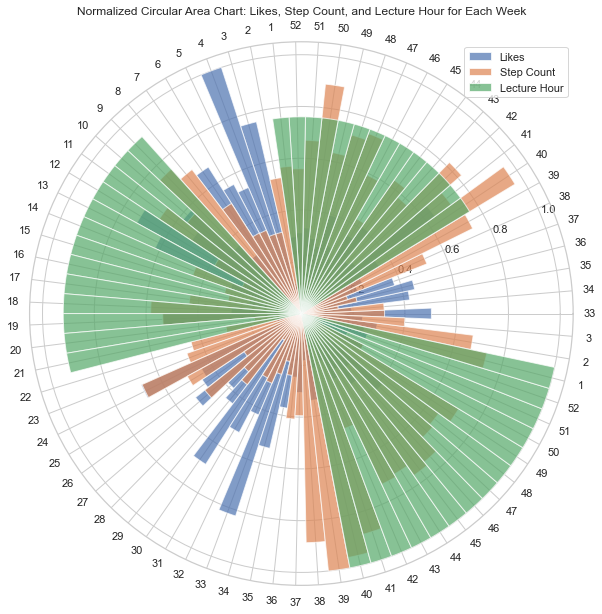

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year

df_weekly_avg = df_filtered.groupby(['year', 'week']).agg({
    'likes': 'mean',
    'step_count': 'mean',
    'Lecture Hour': 'mean'
}).reset_index()

scaler = MinMaxScaler()
df_weekly_avg[['likes', 'step_count', 'Lecture Hour']] = scaler.fit_transform(df_weekly_avg[['likes', 'step_count', 'Lecture Hour']])

plt.figure(figsize=(10, 10))

theta = np.linspace(0, 2*np.pi, len(df_weekly_avg['week']), endpoint=False)
width = 2*np.pi / len(df_weekly_avg['week'])

ax = plt.subplot(111, projection='polar')
ax.bar(theta, df_weekly_avg['likes'], width=width, alpha=0.7, label='Likes')

ax.bar(theta, df_weekly_avg['step_count'], width=width, alpha=0.7, label='Step Count')

ax.bar(theta, df_weekly_avg['Lecture Hour'], width=width, alpha=0.7, label='Lecture Hour')

ax.set_xticks(theta)
ax.set_xticklabels(df_weekly_avg['week'])
ax.set_title('Normalized Circular Area Chart: Likes, Step Count, and Lecture Hour for Each Week')
ax.legend(loc='upper right')

plt.show()


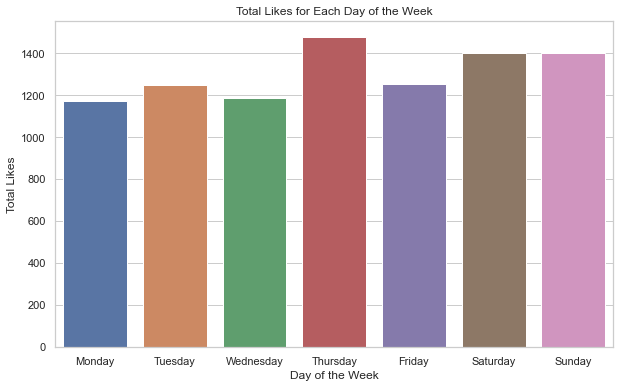

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.day_name()

df_day_of_week_total_likes = df_filtered.groupby('day_of_week')['likes'].sum().reset_index()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='likes', data=df_day_of_week_total_likes, order=day_order)
plt.xlabel('Day of the Week')
plt.ylabel('Total Likes')
plt.title('Total Likes for Each Day of the Week')
plt.show()


In [45]:
df_filtered

date  step_count  likes  Lecture Hour  week  year    month  \
0   2022-08-15      9180.0    7.0           0.0    33  2022  2022-08   
1   2022-08-16       102.0   17.0           0.0    33  2022  2022-08   
2   2022-08-17       727.0   49.0           0.0    33  2022  2022-08   
3   2022-08-18       168.0   54.0           0.0    33  2022  2022-08   
4   2022-08-19      2000.0   21.0           0.0    33  2022  2022-08   
..         ...         ...    ...           ...   ...   ...      ...   
514 2024-01-11      5648.0   12.0           0.0     2  2024  2024-01   
515 2024-01-12      5475.0    2.0           0.0     2  2024  2024-01   
516 2024-01-13      9965.0   45.0           0.0     2  2024  2024-01   
517 2024-01-14      9661.0   27.0           0.0     2  2024  2024-01   
518 2024-01-15      4631.0   13.0           0.0     3  2024  2024-01   

    day_of_week  
0        Monday  
1       Tuesday  
2     Wednesday  
3      Thursday  
4        Friday  
..          ...  
514    Thursday  
515      Friday  
516    Saturday  
517      Sunday  
518      Monday  

[519 rows x 8 columns]

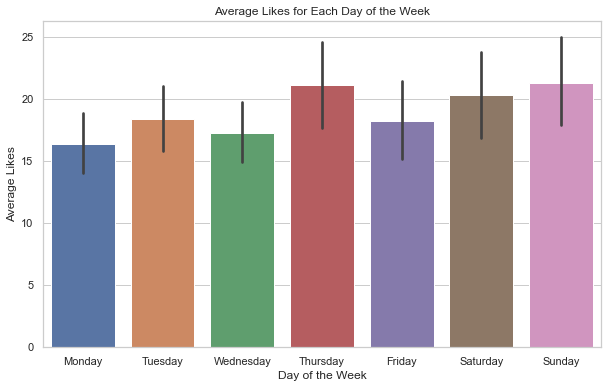

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='likes', data=df_filtered, order=day_order)
plt.xlabel('Day of the Week')
plt.ylabel('Average Likes')
plt.title('Average Likes for Each Day of the Week')
plt.show()


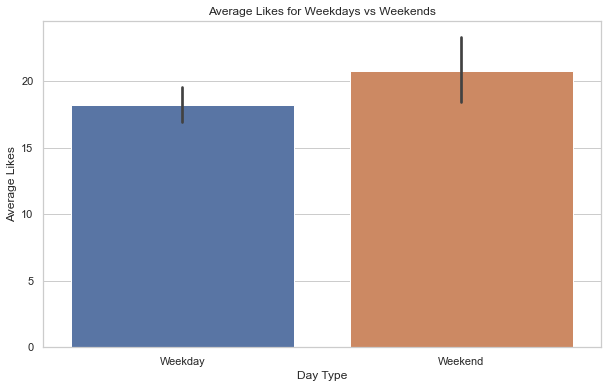

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

df_filtered['day_type'] = df_filtered['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_type', y='likes', data=df_filtered)
plt.xlabel('Day Type')
plt.ylabel('Average Likes')
plt.title('Average Likes for Weekdays vs Weekends')
plt.show()


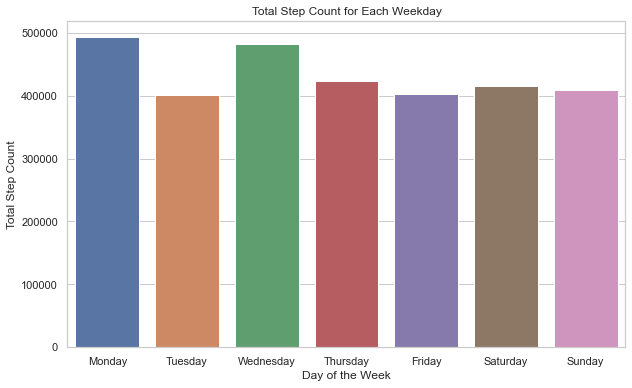

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

df_weekday_total_steps = df_filtered.groupby('day_of_week')['step_count'].sum().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='step_count', data=df_weekday_total_steps)
plt.xlabel('Day of the Week')
plt.ylabel('Total Step Count')
plt.title('Total Step Count for Each Weekday')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


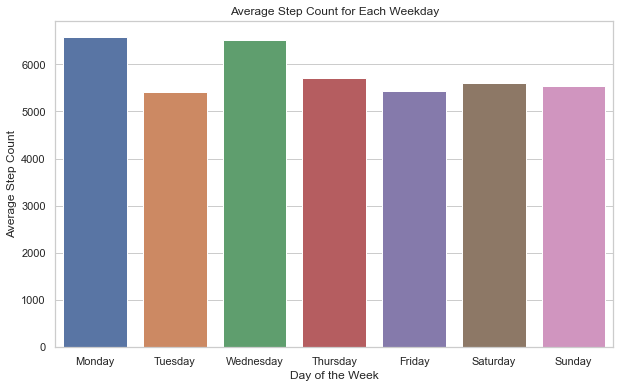

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

df_weekday_avg_steps = df_filtered.groupby('day_of_week')['step_count'].mean().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='step_count', data=df_weekday_avg_steps)
plt.xlabel('Day of the Week')
plt.ylabel('Average Step Count')
plt.title('Average Step Count for Each Weekday')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


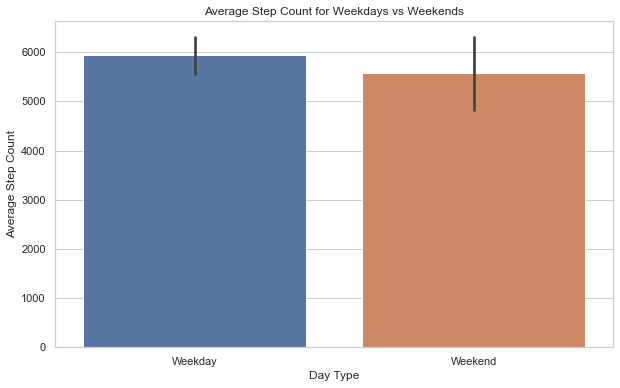

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

df_filtered['day_type'] = df_filtered['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_type', y='step_count', data=df_filtered)
plt.xlabel('Day Type')
plt.ylabel('Average Step Count')
plt.title('Average Step Count for Weekdays vs Weekends')
plt.show()


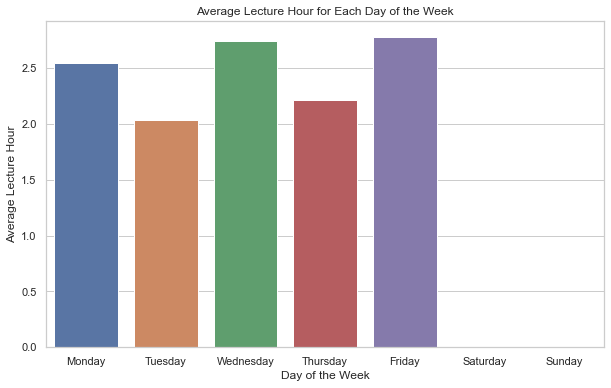

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='Lecture Hour', data=df_filtered, ci=None)  
plt.xlabel('Day of the Week')
plt.ylabel('Average Lecture Hour')
plt.title('Average Lecture Hour for Each Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


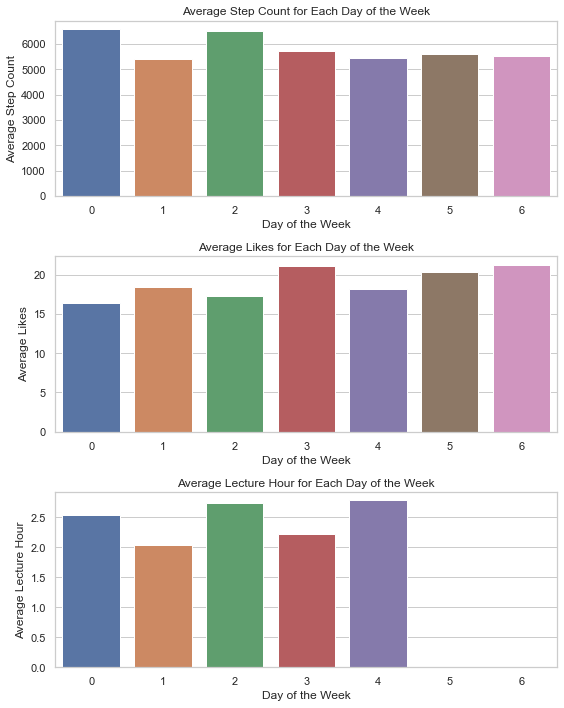

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

sns.set(style="whitegrid")

plt.figure(figsize=(8, 10))

plt.subplot(3, 1, 1)
sns.barplot(x='day_of_week', y='step_count', data=df_filtered, ci=None)
plt.xlabel('Day of the Week')
plt.ylabel('Average Step Count')
plt.title('Average Step Count for Each Day of the Week')

plt.subplot(3, 1, 2)
sns.barplot(x='day_of_week', y='likes', data=df_filtered, ci=None)
plt.xlabel('Day of the Week')
plt.ylabel('Average Likes')
plt.title('Average Likes for Each Day of the Week')

plt.subplot(3, 1, 3)
sns.barplot(x='day_of_week', y='Lecture Hour', data=df_filtered, ci=None)
plt.xlabel('Day of the Week')
plt.ylabel('Average Lecture Hour')
plt.title('Average Lecture Hour for Each Day of the Week')

plt.tight_layout()
plt.show()


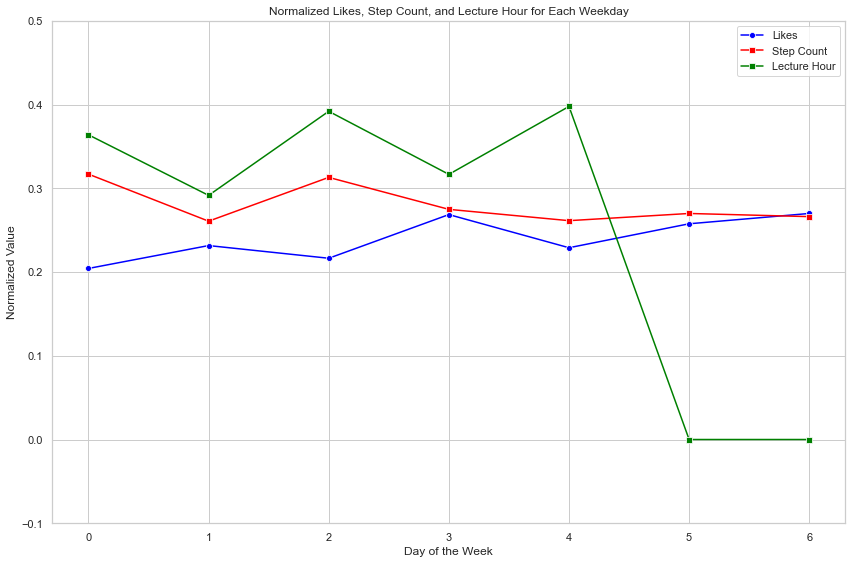

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

sns.set(style="whitegrid")

df_weekdays = df_filtered[df_filtered['day_of_week'] < 8]

scaler = MinMaxScaler()
df_normalized = df_weekdays.copy()
df_normalized[['likes', 'step_count', 'Lecture Hour']] = scaler.fit_transform(df_normalized[['likes', 'step_count', 'Lecture Hour']])

plt.figure(figsize=(12, 8))

sns.lineplot(x='day_of_week', y='likes', data=df_normalized, ci=None, color='blue', marker='o', label='Likes')
sns.lineplot(x='day_of_week', y='step_count', data=df_normalized, ci=None, color='red', marker='s', label='Step Count')
sns.lineplot(x='day_of_week', y='Lecture Hour', data=df_normalized, ci=None, color='green', marker='s', label='Lecture Hour')

plt.ylim(-0.1, 0.5)

plt.xlabel('Day of the Week')
plt.ylabel('Normalized Value')
plt.title('Normalized Likes, Step Count, and Lecture Hour for Each Weekday')

plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


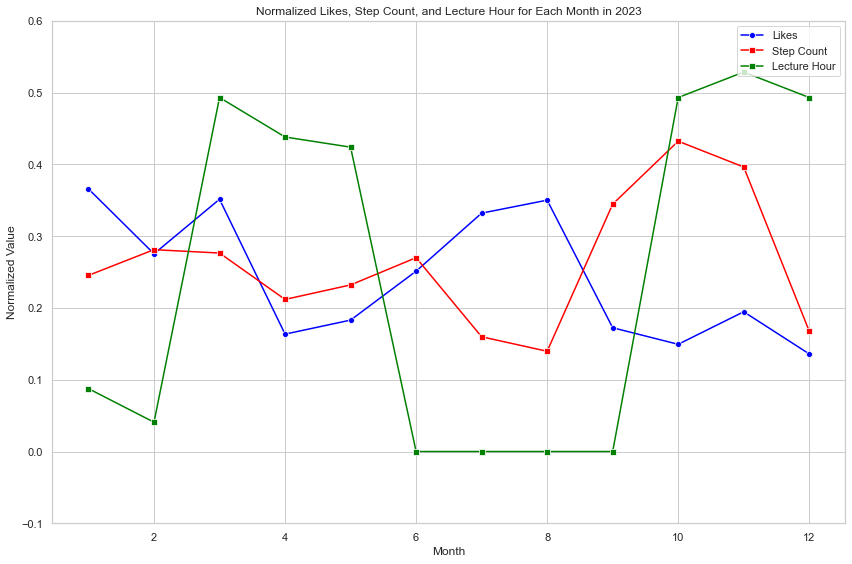

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['year'] = df_filtered['date'].dt.year

df_2023 = df_filtered[(df_filtered['year'] == 2023) & (df_filtered['day_of_week'] < 8)]

scaler = MinMaxScaler()
df_normalized = df_2023.copy()
df_normalized[['likes', 'step_count', 'Lecture Hour']] = scaler.fit_transform(df_normalized[['likes', 'step_count', 'Lecture Hour']])

plt.figure(figsize=(12, 8))

sns.lineplot(x='month', y='likes', data=df_normalized, ci=None, color='blue', marker='o', label='Likes')
sns.lineplot(x='month', y='step_count', data=df_normalized, ci=None, color='red', marker='s', label='Step Count')
sns.lineplot(x='month', y='Lecture Hour', data=df_normalized, ci=None, color='green', marker='s', label='Lecture Hour')

plt.ylim(-0.1, 0.6)

plt.xlabel('Month')
plt.ylabel('Normalized Value')
plt.title('Normalized Likes, Step Count, and Lecture Hour for Each Month in 2023')

plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


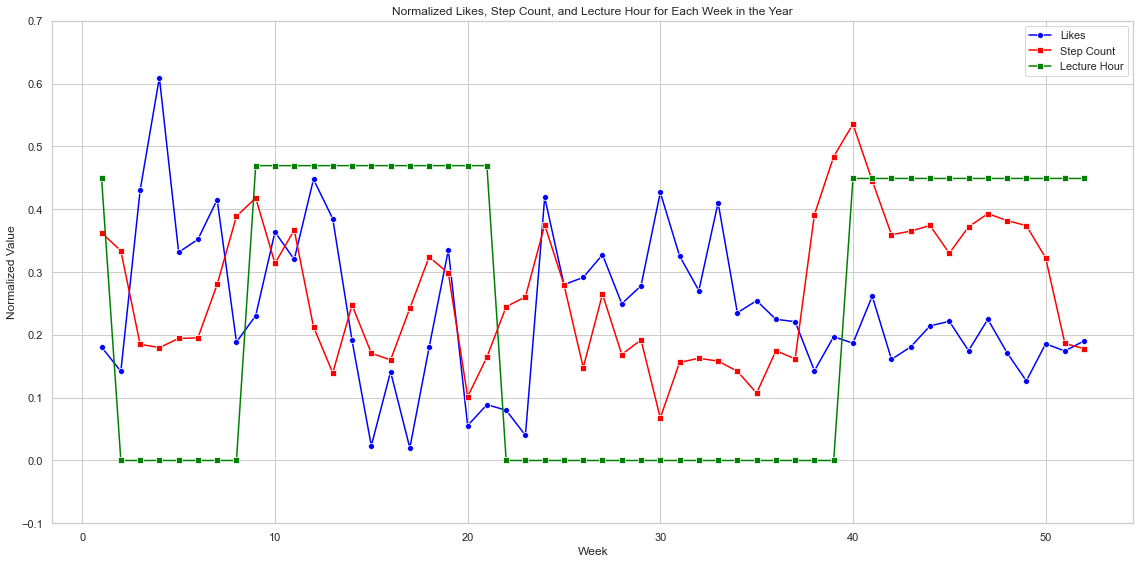

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['week'] = df_filtered['date'].dt.isocalendar().week
df_filtered['year'] = df_filtered['date'].dt.isocalendar().year
df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek

scaler = MinMaxScaler()
df_normalized = df_filtered.copy()
df_normalized[['likes', 'step_count', 'Lecture Hour']] = scaler.fit_transform(df_normalized[['likes', 'step_count', 'Lecture Hour']])

plt.figure(figsize=(16, 8))

sns.lineplot(x='week', y='likes', data=df_normalized, ci=None, color='blue', marker='o', label='Likes')
sns.lineplot(x='week', y='step_count', data=df_normalized, ci=None, color='red', marker='s', label='Step Count')
sns.lineplot(x='week', y='Lecture Hour', data=df_normalized, ci=None, color='green', marker='s', label='Lecture Hour')

plt.ylim(-0.1, 0.7)

plt.xlabel('Week')
plt.ylabel('Normalized Value')
plt.title('Normalized Likes, Step Count, and Lecture Hour for Each Week in the Year')

plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Machine Learning

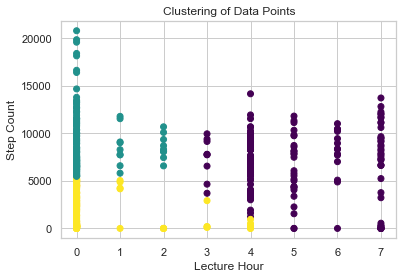

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features_for_clustering = df_filtered[['Lecture Hour', 'step_count']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(scaled_features)

plt.scatter(df_filtered['Lecture Hour'], df_filtered['step_count'], c=df_filtered['cluster'], cmap='viridis', marker='o')
plt.xlabel('Lecture Hour')
plt.ylabel('Step Count')
plt.title('Clustering of Data Points')
plt.show()


In [57]:
df_filtered

date  step_count  likes  Lecture Hour  week  year  month  \
0   2022-08-15      9180.0    7.0           0.0    33  2022      8   
1   2022-08-16       102.0   17.0           0.0    33  2022      8   
2   2022-08-17       727.0   49.0           0.0    33  2022      8   
3   2022-08-18       168.0   54.0           0.0    33  2022      8   
4   2022-08-19      2000.0   21.0           0.0    33  2022      8   
..         ...         ...    ...           ...   ...   ...    ...   
514 2024-01-11      5648.0   12.0           0.0     2  2024      1   
515 2024-01-12      5475.0    2.0           0.0     2  2024      1   
516 2024-01-13      9965.0   45.0           0.0     2  2024      1   
517 2024-01-14      9661.0   27.0           0.0     2  2024      1   
518 2024-01-15      4631.0   13.0           0.0     3  2024      1   

     day_of_week day_type  cluster  
0              0  Weekday        1  
1              1  Weekday        2  
2              2  Weekday        2  
3              3  Weekday        2  
4              4  Weekday        2  
..           ...      ...      ...  
514            3  Weekday        1  
515            4  Weekday        1  
516            5  Weekend        1  
517            6  Weekend        1  
518            0  Weekday        2  

[519 rows x 10 columns]

In [58]:
import pandas as pd

df_filtered['interaction_term'] = df_filtered['Lecture Hour'] * df_filtered['step_count']

df_filtered.isnull()

date  step_count  likes  Lecture Hour   week   year  month  day_of_week  \
0    False       False  False         False  False  False  False        False   
1    False       False  False         False  False  False  False        False   
2    False       False  False         False  False  False  False        False   
3    False       False  False         False  False  False  False        False   
4    False       False  False         False  False  False  False        False   
..     ...         ...    ...           ...    ...    ...    ...          ...   
514  False       False  False         False  False  False  False        False   
515  False       False  False         False  False  False  False        False   
516  False       False  False         False  False  False  False        False   
517  False       False  False         False  False  False  False        False   
518  False       False  False         False  False  False  False        False   

     day_type  cluster  interaction_term  
0       False    False             False  
1       False    False             False  
2       False    False             False  
3       False    False             False  
4       False    False             False  
..        ...      ...               ...  
514     False    False             False  
515     False    False             False  
516     False    False             False  
517     False    False             False  
518     False    False             False  

[519 rows x 11 columns]

In [59]:
import statsmodels.api as sm

X = sm.add_constant(df_filtered[['Lecture Hour', 'step_count', 'interaction_term']])
y = df_filtered['likes']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 19 Jan 2024   Prob (F-statistic):                nan
Time:                        14:24:17   Log-Likelihood:                    nan
No. Observations:                 519   AIC:                               nan
Df Residuals:                     515   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                   nan        nan  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_shuffled = df_filtered.sample(frac=1, random_state=42)

y_column = 'likes'
X_columns = df_shuffled.drop(columns=[y_column]).columns.tolist()

X = df_shuffled[X_columns]
y = df_shuffled[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (415, 10), y_train shape: (415,)
X_test shape: (104, 10), y_test shape: (104,)


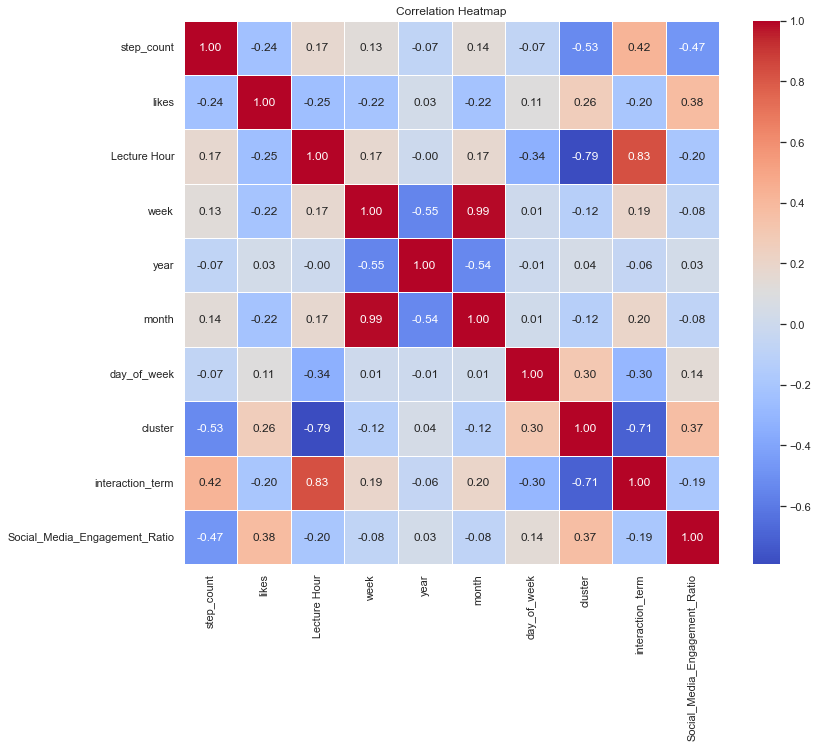

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
df_filtered['Social_Media_Engagement_Ratio'] = df_filtered['likes'] / df_filtered['step_count']

correlations = df_filtered.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [62]:
selected_features = correlations['likes'][(correlations['likes'] > 0.3) | (correlations['likes'] < -0.3)].index.tolist()

print("Selected Features:")
print(selected_features)


Selected Features:
['likes', 'Social_Media_Engagement_Ratio']


In [63]:
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])

print("Numeric Columns:")
print(X_train_numeric.columns)

Numeric Columns:
Index(['step_count', 'Lecture Hour', 'month', 'day_of_week',
       'interaction_term'],
      dtype='object')


In [64]:
print("Shape of X_train_numeric:", X_train_numeric.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_numeric: (415, 5)
Shape of y_train: (415,)


In [65]:
Xy_train = pd.concat([X_train_numeric, y_train], axis=1)

Xy_train.replace([np.inf, -np.inf], np.nan, inplace=True)

Xy_train_cleaned = Xy_train.dropna()

X_train_numeric_cleaned = Xy_train_cleaned.drop(columns=['likes'])
y_train_cleaned = Xy_train_cleaned['likes']

print(f"Original X_train_numeric shape: {X_train_numeric.shape}")
print(f"Cleaned X_train_numeric shape: {X_train_numeric_cleaned.shape}")
print(f"Original y_train shape: {y_train.shape}")
print(f"Cleaned y_train shape: {y_train_cleaned.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_train_numeric_cleaned, y_train_cleaned, test_size=0.2, random_state=42)


Original X_train_numeric shape: (415, 5)
Cleaned X_train_numeric shape: (386, 5)
Original y_train shape: (415,)
Cleaned y_train shape: (386,)


In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

best_dtree = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)

best_dtree.fit(X_train, y_train)

y_pred = best_dtree.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse}")


Mean Squared Error on the test set: 169.1044078130208


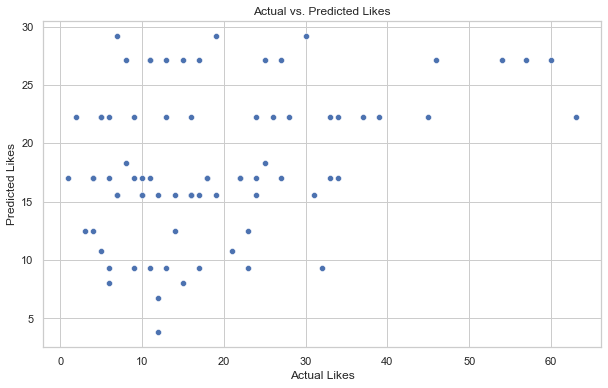

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Likes')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.show()


In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 426.44
R-squared: -1.24


In [69]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")


Random Forest Mean Squared Error: 174.45
Random Forest R-squared: 0.08


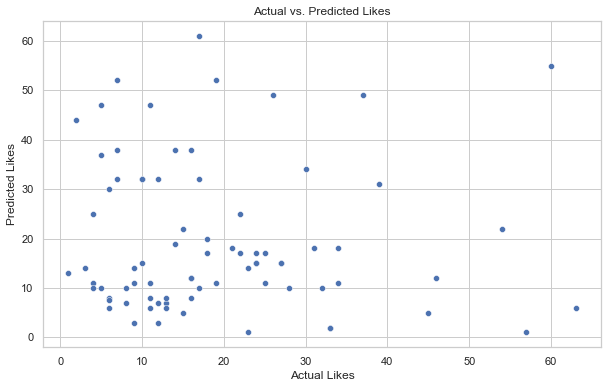

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs. Predicted Likes')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.show()


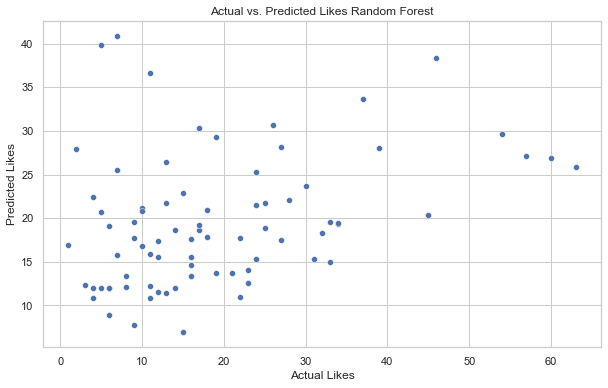

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.title('Actual vs. Predicted Likes Random Forest')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.show()


In [72]:
import pandas as pd

day_of_week_avg_step_count = df_filtered.groupby('day_of_week')['step_count'].mean()

new_week_data = pd.DataFrame({'Lecture Hour': [5, 4, 4, 2, 5, 0, 0]})

new_week_data['average_step_count'] = new_week_data['Lecture Hour'].map(day_of_week_avg_step_count)
new_week_data['month'] = df_filtered['month'].mean()
new_week_data['interaction_term'] = new_week_data['Lecture Hour'] * new_week_data['average_step_count']

day_of_week_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
new_week_data['day_of_week'] = new_week_data['Lecture Hour'].map(day_of_week_mapping)

print(new_week_data)


   Lecture Hour  average_step_count     month  interaction_term  day_of_week
0             5         5612.567568  7.350674      28062.837838            5
1             4         5433.932432  7.350674      21735.729730            4
2             4         5433.932432  7.350674      21735.729730            4
3             2         6508.621622  7.350674      13017.243243            2
4             5         5612.567568  7.350674      28062.837838            5
5             0         6588.973333  7.350674          0.000000            0
6             0         6588.973333  7.350674          0.000000            0


In [73]:
predicted_likes_rf = rf_model.predict(new_week_data)
predicted_likes_dt = tree_model.predict(new_week_data)

In [74]:
print(predicted_likes_rf)
print(predicted_likes_dt)

[12.61116667 12.61116667 12.61116667 12.61116667 12.61116667 12.9945
 12.9945    ]
[5. 5. 5. 5. 5. 5. 5.]
